# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
  1
 -1
  1
 -1
  1
 -1
  1
  ⋮
 -1
  1
 -1
 -1
 -1
  1
  1
  1
 -1

### We create a function to visualize the data

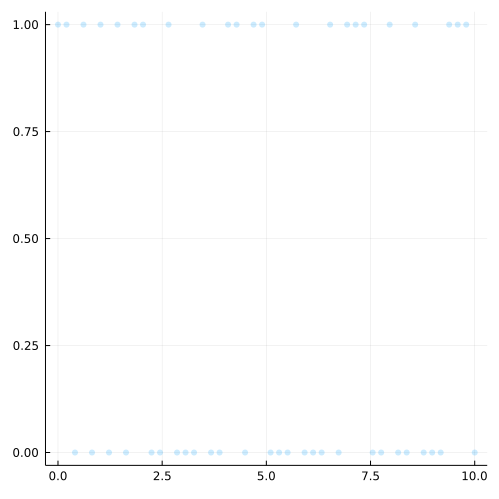

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.880874 seconds (1.85 M allocations: 98.309 MiB, 99.54% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8266408423119767, 0.7781322787495667, 0.7321977943596162, 0.6926190325273696, 0.6608075585675025, 0.6364650158965905, 0.6181205991905683, 0.605368321766016, 0.5996673109135067, 0.6045186657357106  …  0.6770890436871492, 0.6992379598884965, 0.7033971847817312, 0.6881919438647504, 0.6610434130013298, 0.6362507835242802, 0.6285693546595467, 0.6454994725862055, 0.6839249866184057, 0.7346305696617775], θ = [0.23667374686932438, 0.2381053231900029, 0.2393989429693294, 0.24046305730317824, 0.24128321457056826, 0.2418890783092333, 0.24233294896527177, 0.24263498074024337, 0.24276825811337552, 0.24265491261258834  …  0.24086742250467072, 0.24028843692000496, 0.2401780169052072, 0.240579094999195, 0.241277251399194, 0.2418943254149047, 0.24208147573200803, 0.2416664463509487, 0.2406903581804521

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:24
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:15
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:29
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:24
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:22
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.15338750251604336, 0.4253799824300257, 0.6909977721831059, 0.8805124937617756, 0.9529425184931823, 0.8642550954417599, 0.602673899415573, 0.25475969131171466, -0.1862576114811856, -0.5908020292357807  …  0.2542209437377764, 0.18488831305241687, 0.11042427944699246, 0.1365166964287306, 0.1906505266254213, 0.3716543779567566, 0.5543909535313214, 0.7648066969461598, 0.9459004264485182, 1.0977799674318327]]
 [[1.5375335905880347, 1.2555181096029149, 0.8932650620758806, 0.5319003899844722, 0.1536598863595388, -0.13035179435190278, -0.32304049199216106, -0.44409954928337575, -0.4036818873324243, -0.3321440645819841  …  -0.1955023525635129, -0.2684578555676789, -0.35211353079994767, -0.43874821501901595, -0.5519306694402523, -0.6178181370829928, -0.6324408827749738, -0.6500550841461941, -0.6320030950013054, -0.6330252584537663]]
 [[-0.1049223615876701, -0.09305466684289093, -0.08268752626222758, -0.14362144583378073, -0.22104224595973287, -0.

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

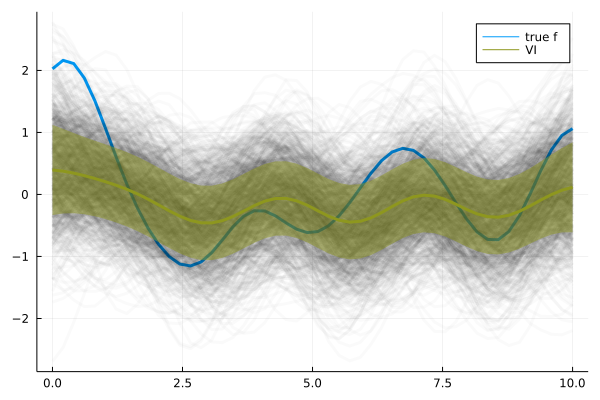

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

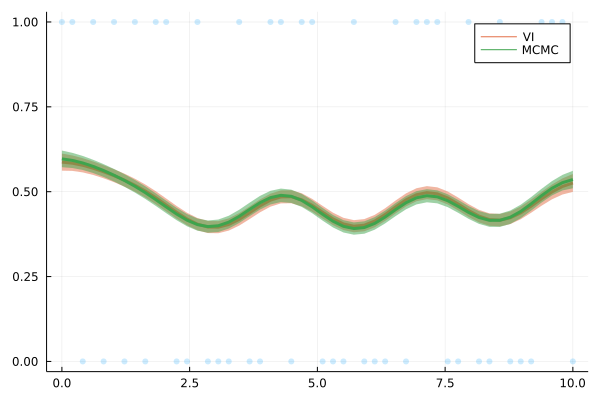

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*